# Link labeldata to window cut-outs

In [1]:
# %pip install rioxarray
# %pip install geopandas

In [2]:
import numpy as np
import rasterio
from rasterio.features import shapes, geometry_mask
import rioxarray
import json

dataPath = '/Users/maaikeizeboud/Documents/Data/test/'
imName = 'S2_comp_first.tif'
# labName = 'S2_20190131_-100p7_-75p0.geojson'
labName = 'output.geojson'

## Load Image 


(Kopied from Meierts 'rasterize_labeled_data.ipynb')

In [4]:
bands = rioxarray.open_rasterio(dataPath + imName)
bands.rio.bounds()

(-1653920.0, -366670.0, -1553880.0, -266650.0)

In [5]:
bands.rio.crs

CRS.from_epsg(3031)

In [6]:
bands.spatial_ref.crs_wkt

'PROJCRS["WGS 84 / Antarctic Polar Stereographic",BASEGEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["unnamed",METHOD["Polar Stereographic (variant B)",ID["EPSG",9829]],PARAMETER["Latitude of standard parallel",-71,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8832]],PARAMETER["Longitude of origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8833]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["easting",north,ORDER[1],LENGTHUNIT["metre",1]],AXIS["northing",north,ORDER[2],LENGTHUNIT["metre",1]],ID["EPSG",3031]]'

## Load labeldata 

labeldata.geojson contains both Polygon and MultiLine. 

NB: the labeldata is stored in EPSG:4325 projection,  (lat,lon) values.
This is converted to EPSG:3031 projection (Antarctic polarstereographic) BEFORE LOADING HERE. 
This has been done in terminal, not in this notebook, using GDAL's ogr2ogr: ``ogr2ogr   -s_srs EPSG:4326 -t_srs EPSG:3031  output.geojson   input.geojson``

In [7]:
with open(dataPath + labName) as f:
    gj = json.load(f)

features = gj['features'][0]['geometry'] # select one feature polygon for testing

len(gj)

4

### Check if geometry is valid geojson geomtetry to input to rasterio.features
Even though the features are recognised as is_valid_geom()=True, 
using this as input for rasterio.features.geometry_mask(geometries,...) (see later kernel) yields:
``ValueError: No valid geometry objects found for rasterize`` 

In [8]:
print(rasterio.features.is_valid_geom(features))

True


### Convert poly to georegisterted polygon
Would rather skip this step, if we can get geometry_mask to work with 'features' geometry

ATTENTION: should test for MultiLine as well (now only Polygon)

In [9]:
from geopandas import GeoSeries
from shapely import geometry
from shapely.geometry import shape, mapping, MultiPolygon
# poly1 = geometry.Polygon([[p.x,p.y] for p in plist1])
poly = np.squeeze(features['coordinates']) # ndarray

poly1 = geometry.Polygon(poly)
polys = GeoSeries([poly1],crs=bands.spatial_ref.crs_wkt)
type(polys)


geopandas.geoseries.GeoSeries

## Create mask with rasterio.features.geometry_mask

### (1) use georegistered polygon -- works
create mask based on geometry. Invert mask to select pixels WITHIN bounds. ATTENTION possible to select on touch or center inclusion

polys : dtype geometry / geopandas.geoseries.GeoSeries

In [10]:
mmask = geometry_mask(polys,out_shape=(len(bands.y),len(bands.x)),transform=bands.rio.transform(),invert=True)

# Inspect data type of mask -> ndarray
# mmask = np.expand_dims(mmask,axis=0)
# mmask.shape

### (2) use geojson-like object  -- doesnt work
https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html
GeoJSON-like objects should work, and would save some conversion from geojson > polygon > georegistered polygon. 

In [12]:

mmask = geometry_mask(features,out_shape=(len(bands.y),len(bands.x)),transform=bands.rio.transform(),invert=True)


ValueError: No valid geometry objects found for rasterize

In [13]:
m2mask = mmask.astype(np.dtype('uint16'))

inspect mask

Text(0.5, 1.0, 'image (1/3 bnd)')

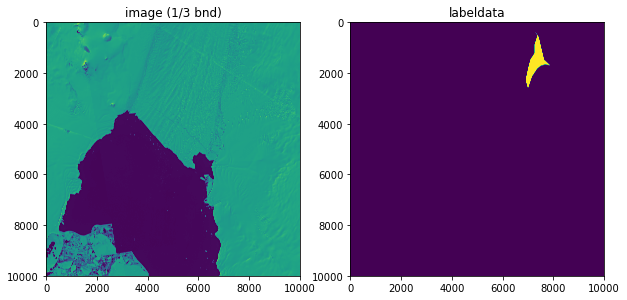

In [25]:
import matplotlib.pyplot as plt
# imshow(amask[0])
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
ax2.imshow(m2mask)
ax1.imshow(bands[1,:,:]) 
ax2.set_title('labeldata');
ax1.set_title('image (1/3 bnd)');